### Step 2 ML Risk Score Prediction Pipeline
**Author:** John Michael <br>
**Purpose:** The primary purpose of this notebook is to train the best ML model that can predict the patient's choice to undergo spinal surgery on a scale of 0 to 100 based on features such as demographics, ODI, ADI, and DOSPERT as well as inputs such as the percentage of complication and percentage of improvement.

In [3]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import pickle
sns.set_theme()
pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_csv("../../data/data_processed/ml_data_w_risk_questions_processed_final.csv")
data.head()

,ohe__religion_10,cat__sex,cat__income,cat__education,cat__prior_surg,cat__succ_surg,num__age,num__odi_final,num__bmi,num__dospert_ethical,...,work_50improv_90para,work_90improv_1para,work_90improv_10para,work_90improv_50para,work_50improv_1death,work_50improv_10death,work_50improv_50death,work_90improv_1death,work_90improv_10death,work_90improv_50death
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,0,5,5,0,5,3,0,5,5,0
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,0,5,3,2,4,2,1,5,3,1
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,0,2,1,0,1,0,0,1,0,0
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0,4,3,0,3,0,0,3,2,0
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,0,5,4,1,5,4,1,5,4,1


In [5]:
# Fix column names
cols = list(data.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
data.columns = new_cols

# Drop spinal risk score
data.drop(columns=['spinal_risk_score'], inplace=True)
data.columns

Index(['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
       'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
       'dospert_health/safety', 'dospert_recreational', 'dospert_social',
       'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK',
       'exer_50improv_1drop', 'exer_50improv_10drop', 'exer_50improv_50drop',
       'exer_50improv_90drop', 'exer_90improv_1drop', 'exer_90improv_10drop',
       'exer_90improv_50drop', 'exer_90improv_90drop', 'exer_50pain_1death',
       'exer_50pain_10death', 'exer_50pain_50death', 'exer_90pain_1death',
       'exer_90pain_10death', 'exer_90pain_50death', 'work_50improv_1drop',
       'work_50improv_10drop', 'work_50improv_50drop', 'work_50improv_90drop',
       'work_90improv_1drop', 'work_90improv_10drop', 'work_90improv_50drop',
       'work_50improv_1para', 'work_50improv_10para', 'work_50improv_50para',
       'work_50improv_90para', 'work_90improv_1para', 'work_90improv_10para',
       'work_

In [6]:
'''
Reshape the data from wide to long where each row represents one risk scenario.
'''
data_long = pd.melt(data,
                    id_vars=['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
                             'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
                             'dospert_health/safety', 'dospert_recreational', 'dospert_social',
                             'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK'],
                    var_name='risk_question', value_name='choice')
split_df = data_long['risk_question'].str.split('_', expand=True)
data_long['activity'] = split_df[0]
data_long['pct_improv'] = split_df[1].str.extract(r'(\d{1,})', expand=False)
data_long['comp'] = split_df[2].str.extract(r'(drop|para|death)', expand=False)
data_long['pct_comp'] = split_df[2].str.extract(r'(\d{1,})', expand=False)
for c in ['pct_improv', 'pct_comp']:
    data_long[c] = pd.to_numeric(data_long[c])

In [7]:
ohe_cols = ['activity', 'comp']
num_cols = ['pct_improv', 'pct_comp']

In [8]:
# define preprocessing pipeline
ohe_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_cols),
        ('num', num_pipe, num_cols)
    ])

to_process_df = data_long[ohe_cols + num_cols].copy()
to_process_df
preprocessor.fit(to_process_df)  # Fit the ColumnTransformer to your data
transformed_columns = preprocessor.get_feature_names_out(input_features=to_process_df.columns)

processed = preprocessor.transform(to_process_df)
processed_df = pd.DataFrame(processed, columns=transformed_columns)
cols = list(processed_df.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
processed_df.columns = new_cols
drop_cols = ohe_cols + num_cols + ['risk_question']
data_long.drop(columns=drop_cols, inplace=True)
model_data = pd.concat([data_long, processed_df], axis=1)
model_data.head()

,religion_10,sex,income,education,prior_surg,succ_surg,age,odi_final,bmi,dospert_ethical,...,height_m,weight_kg,ADI_NATRANK,ADI_STATERNK,choice,activity_work,comp_drop,comp_para,pct_improv,pct_comp
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,-0.551831,-1.100657,-0.450913,-1.118697,4,0.0,1.0,0.0,-0.942809,-0.915608
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,1.178208,-0.223692,0.320334,0.337078,4,0.0,1.0,0.0,-0.942809,-0.915608
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,-1.046128,-1.335940,0.026525,-0.754753,3,0.0,1.0,0.0,-0.942809,-0.915608
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0.683911,0.931335,-1.662873,-1.482640,3,0.0,1.0,0.0,-0.942809,-0.915608
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,1.425357,0.396601,-0.597818,-1.482640,5,0.0,1.0,0.0,-0.942809,-0.915608


In [7]:
# Saving processor pipeline to pickle object
with open('../../data/ml_models/choice_model_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [9]:
X = model_data.drop(['choice'], axis=1)  # All columns except the last one are predictors
y = model_data['choice'].to_numpy()   # The last column is the response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [11]:
#######################
search_method = 'random' # Whether to use random search or grid search
degree = 2 # Defines the polynomial transformation to use
#######################

# Define models
models = {
    'XGBoost': XGBRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'XGBoost': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Ridge': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'Lasso': {
        'alpha': np.logspace(-4, 4, 40),  # Regularization strength
        'max_iter': [1000, 5000, 10000],  # Maximum number of iterations
    }
}
# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
best_params = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if search_method == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6,
                                       scoring='neg_mean_squared_error')
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=300,
                                                   cv=10, scoring='neg_mean_squared_error',
                                                   random_state=42)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('model', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if search_method == 'grid':
        best_validation_score = grid_search.best_score_
        best_params[model_name] = grid_search.best_params_
    else:
        best_validation_score = randomized_search.best_score_
        best_params[model_name] = randomized_search.best_params_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Mean Squared Error: {best_validation_mse}')

    # Saving the training predictions and models
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline

    # Saving the hyperparameters and cross validation results to csv files
    rsearch_df = pd.DataFrame(randomized_search.cv_results_)
    rsearch_df.to_csv(
        f'../../data/model_training/polydegree{degree}/choice_model_cv_results_{model_name}.csv',
        index=False)

In [12]:
# Analyzing the results of the random search
degrees = [1, 2]
start = 1
for degree in degrees:
    for model_name in models.keys():
        cv_results = pd.read_csv(
            f'../../data/model_training/polydegree{degree}/choice_model_cv_results_{model_name}.csv')
        num_rows = cv_results.shape[0]
        cv_results['degree'] = [degree for _ in range(num_rows)]
        cv_results['model_name'] = [model_name for _ in range(num_rows)]
        if start == 1:
            final_cv_results = cv_results
            start = 0
        else:
            final_cv_results = pd.concat([final_cv_results, cv_results], axis=0)

final_cv_results['mean_test_score'] = final_cv_results['mean_test_score'] * -1
final_cv_results = final_cv_results.drop_duplicates(subset=['params', 'model_name', 'degree'])

The palette list has more values (10) than needed (2), which may not be intended.
FixedFormatter should only be used together with FixedLocator


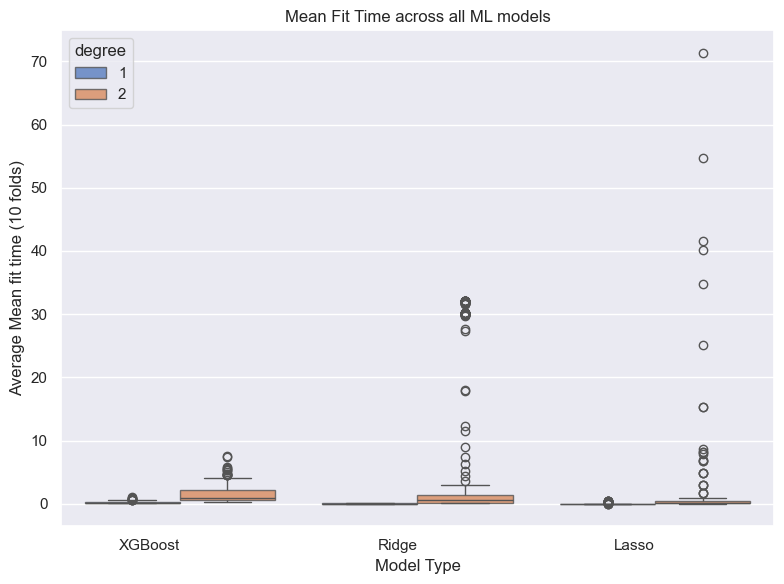

In [21]:
labels = list(final_cv_results['model_name'].unique())

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='mean_fit_time',
            hue='degree', ax=ax, palette=sns.color_palette('muted'),
            boxprops=dict(alpha=.8))
ax.set_xticklabels(labels, rotation=0, ha='right', rotation_mode='anchor')
ax.set_ylabel('Average Mean fit time (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('Mean Fit Time across all ML models')
plt.tight_layout()

The palette list has more values (10) than needed (2), which may not be intended.
FixedFormatter should only be used together with FixedLocator


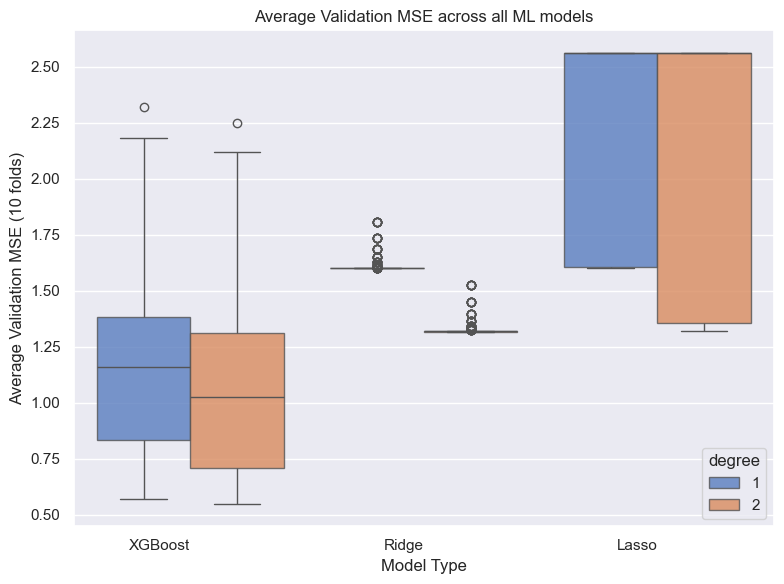

In [22]:
labels = list(final_cv_results['model_name'].unique())

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='mean_test_score', hue='degree', ax=ax,
            palette=sns.color_palette('muted'), boxprops=dict(alpha=.8))
ax.set_xticklabels(labels, rotation=0, ha='right', rotation_mode='anchor')
ax.set_ylabel('Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('../../figures/hp_tuning/all_choice_models_validation_mse.png')
plt.show()

The palette list has more values (10) than needed (2), which may not be intended.
FixedFormatter should only be used together with FixedLocator


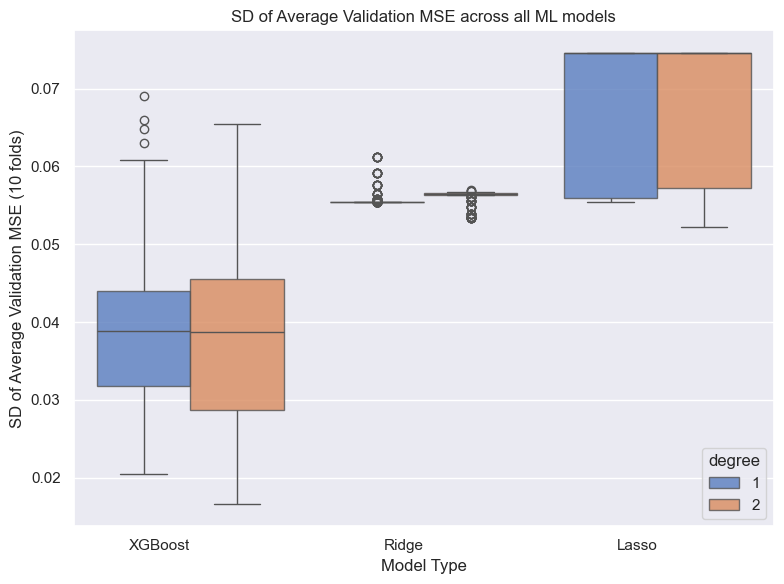

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(final_cv_results, x='model_name', y='std_test_score', hue='degree', ax=ax,
            palette=sns.color_palette('muted'), boxprops=dict(alpha=.8))
ax.set_xticklabels(labels, rotation=0, ha='right', rotation_mode='anchor')
ax.set_ylabel('SD of Average Validation MSE (10 folds)')
ax.set_xlabel('Model Type')
ax.set_title('SD of Average Validation MSE across all ML models')
plt.tight_layout()
plt.savefig('../../figures/hp_tuning/all_choice_models_validation_stdev.png')
plt.show()

In [19]:
# Extracting the best models
best_models_df = final_cv_results[final_cv_results['rank_test_score'] == 1][
    ['model_name', 'degree', 'params', 'mean_test_score']]

In [20]:
# Fitting the best models on the other split
fitted_models_df = best_models_df.copy()
scores_dict = {'train_mse':[], 'train_r2':[], 'test_mse':[], 'test_r2':[]}
for row in best_models_df.itertuples():
    model = models[row.model_name]
    model = model.set_params(**ast.literal_eval(row.params))
    X_train_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_train)
    X_test_transform = PolynomialFeatures(degree=row.degree).fit_transform(X_test)
    model.fit(X_train_transform, y_train)
    y_train_pred = model.predict(X_train_transform)
    y_test_pred = model.predict(X_test_transform)
    scores_dict['train_mse'].append(mean_squared_error(y_true=y_train, y_pred=y_train_pred))
    scores_dict['train_r2'].append(r2_score(y_true=y_train, y_pred=y_train_pred))
    scores_dict['test_mse'].append(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
    scores_dict['test_r2'].append(r2_score(y_true=y_test, y_pred=y_test_pred))
fitted_models_df['train mse'] = scores_dict['train_mse']
fitted_models_df['train R2'] = scores_dict['train_r2']
fitted_models_df['test mse'] = scores_dict['test_mse']
fitted_models_df['test R2'] = scores_dict['test_r2']

fitted_models_unique_df = fitted_models_df.drop_duplicates(subset=['model_name', 'degree',
                                                                   'test mse', 'test R2'])
    

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+02, tolerance: 5.567e+00


In [24]:
# Displaying the models with the best Test MSE and R2 values
fitted_models_df.sort_values(by='test mse')

,model_name,degree,params,mean_test_score,train mse,train R2,test mse,test R2
39,XGBoost,2,"{'subsample': 0.8, 'n_estimators': 190, 'min_c...",0.548666,0.154937,0.939516,0.516399,0.795790
23,XGBoost,1,"{'subsample': 0.5, 'n_estimators': 170, 'min_c...",0.571207,0.180156,0.929671,0.541255,0.785961
2,Lasso,2,"{'max_iter': 10000, 'alpha': 0.0001}",1.317898,1.283215,0.499058,1.359659,0.462324
95,Ridge,2,"{'solver': 'sparse_cg', 'alpha': 0.04641588833...",1.316750,1.281503,0.499727,1.360268,0.462083
15,Lasso,1,"{'max_iter': 1000, 'alpha': 0.0010608183551394...",1.600461,1.597065,0.376537,1.600901,0.366925
16,Lasso,1,"{'max_iter': 5000, 'alpha': 0.0010608183551394...",1.600461,1.597065,0.376537,1.600901,0.366925
17,Lasso,1,"{'max_iter': 10000, 'alpha': 0.001060818355139...",1.600461,1.597065,0.376537,1.600901,0.366925
188,Ridge,1,"{'solver': 'saga', 'alpha': 21.54434690031882}",1.600593,1.596971,0.376574,1.601719,0.366602


The palette list has more values (10) than needed (2), which may not be intended.
FixedFormatter should only be used together with FixedLocator


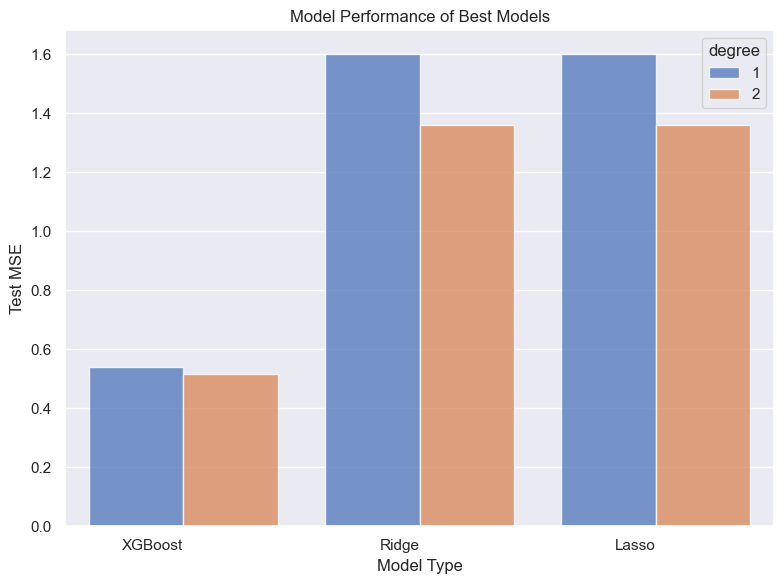

In [28]:
labels = list(final_cv_results['model_name'].unique())
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test mse', hue='degree', ax=ax,
            palette=sns.color_palette('muted'), alpha=.8)
ax.set_xticklabels(labels, rotation=0, ha='right', rotation_mode='anchor')
ax.set_ylabel('Test MSE')
ax.set_xlabel('Model Type')
ax.set_title('Model Performance of Best Models')
plt.tight_layout()
plt.savefig('../../figures/hp_tuning/best_choice_models_test_mse.png')
plt.show()

The palette list has more values (10) than needed (2), which may not be intended.
FixedFormatter should only be used together with FixedLocator


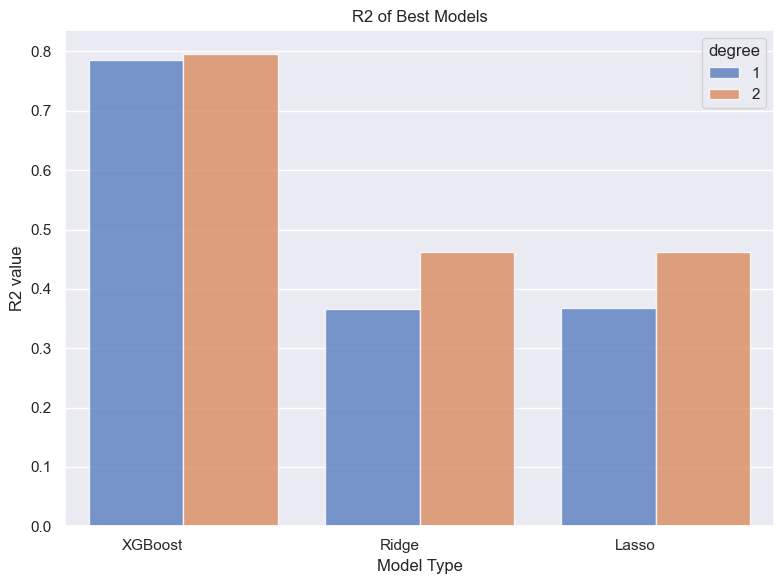

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(fitted_models_unique_df, x='model_name', y='test R2', hue='degree', ax=ax,
            palette=sns.color_palette('muted'), alpha=.8)
ax.set_xticklabels(labels, rotation=0, ha='right')
ax.set_ylabel('R2 value')
ax.set_xlabel('Model Type')
ax.set_title('R2 of Best Models')
plt.tight_layout()
plt.savefig('../../figures/hp_tuning/best_choice_models_test_R2.png')
plt.show()

The best performing model is the XGBoost model with 2nd degree polynomials. However, this model is only marginally better than the 1st degree polynomial XGBoost model but takes much longer to train. As a result, we will go with the best performing 1st degree XGBoost polynomial for the final model.

In [48]:
USE_BEST_DEGREE_1_MODEL = True

# Extract best model parameters
if USE_BEST_DEGREE_1_MODEL:
    best_model_params = fitted_models_unique_df[
        fitted_models_unique_df['degree'] == 1].sort_values(by='test mse').iloc[0, :]    
else:
    best_model_params = fitted_models_unique_df.sort_values(by='test mse').iloc[0, :]
final_model = models[best_model_params.model_name]
final_model = final_model.set_params(**ast.literal_eval(best_model_params.params))

# Transform data
if USE_BEST_DEGREE_1_MODEL:
    X_train_transform = X_train.copy()
else:
    X_train_transform = PolynomialFeatures(degree=best_model_params.degree).fit_transform(X_train)

# Fit final model
final_model = final_model.fit(X_train_transform, y_train)

# Saving the best degree polynomial to pickle object
best_degree = best_model_params.degree
with open('../../data/ml_models/choice_model_best_degree.pkl', 'wb') as f:
    pickle.dump(best_degree, f)

# Saving best model pipeline to pickle object
with open('../../data/ml_models/choice_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [50]:
# Plot SHAP values
with open('../../data/ml_models/choice_model.pkl', 'rb') as f:
    choice_model = pickle.load(f)
with open('../../data/ml_models/choice_model_best_degree.pkl', 'rb') as f:
    best_degree = pickle.load(f)

if best_degree > 1:
    X_train_transform = PolynomialFeatures(degree=best_degree).fit_transform(X_train)
    X_test_transform = PolynomialFeatures(degree=best_degree).fit_transform(X_test)
else:
    X_train_transform = X_train.copy()
    X_test_transform = X_test.copy()

shap.initjs()
explainer = shap.Explainer(choice_model, X_train_transform, max_evals = 1854721)

# Saving the SHAP explainer to pickle object
with open('../../data/ml_models/choice_model_shap.pkl', 'wb') as f:
    pickle.dump(explainer, f)

shap_values = explainer(X_test_transform)

100%|===================| 5411/5434 [01:57<00:00]        

Text(0.5, 1.0, 'SHAP Values of Best Choice Model (XGBoost) on Test Set')

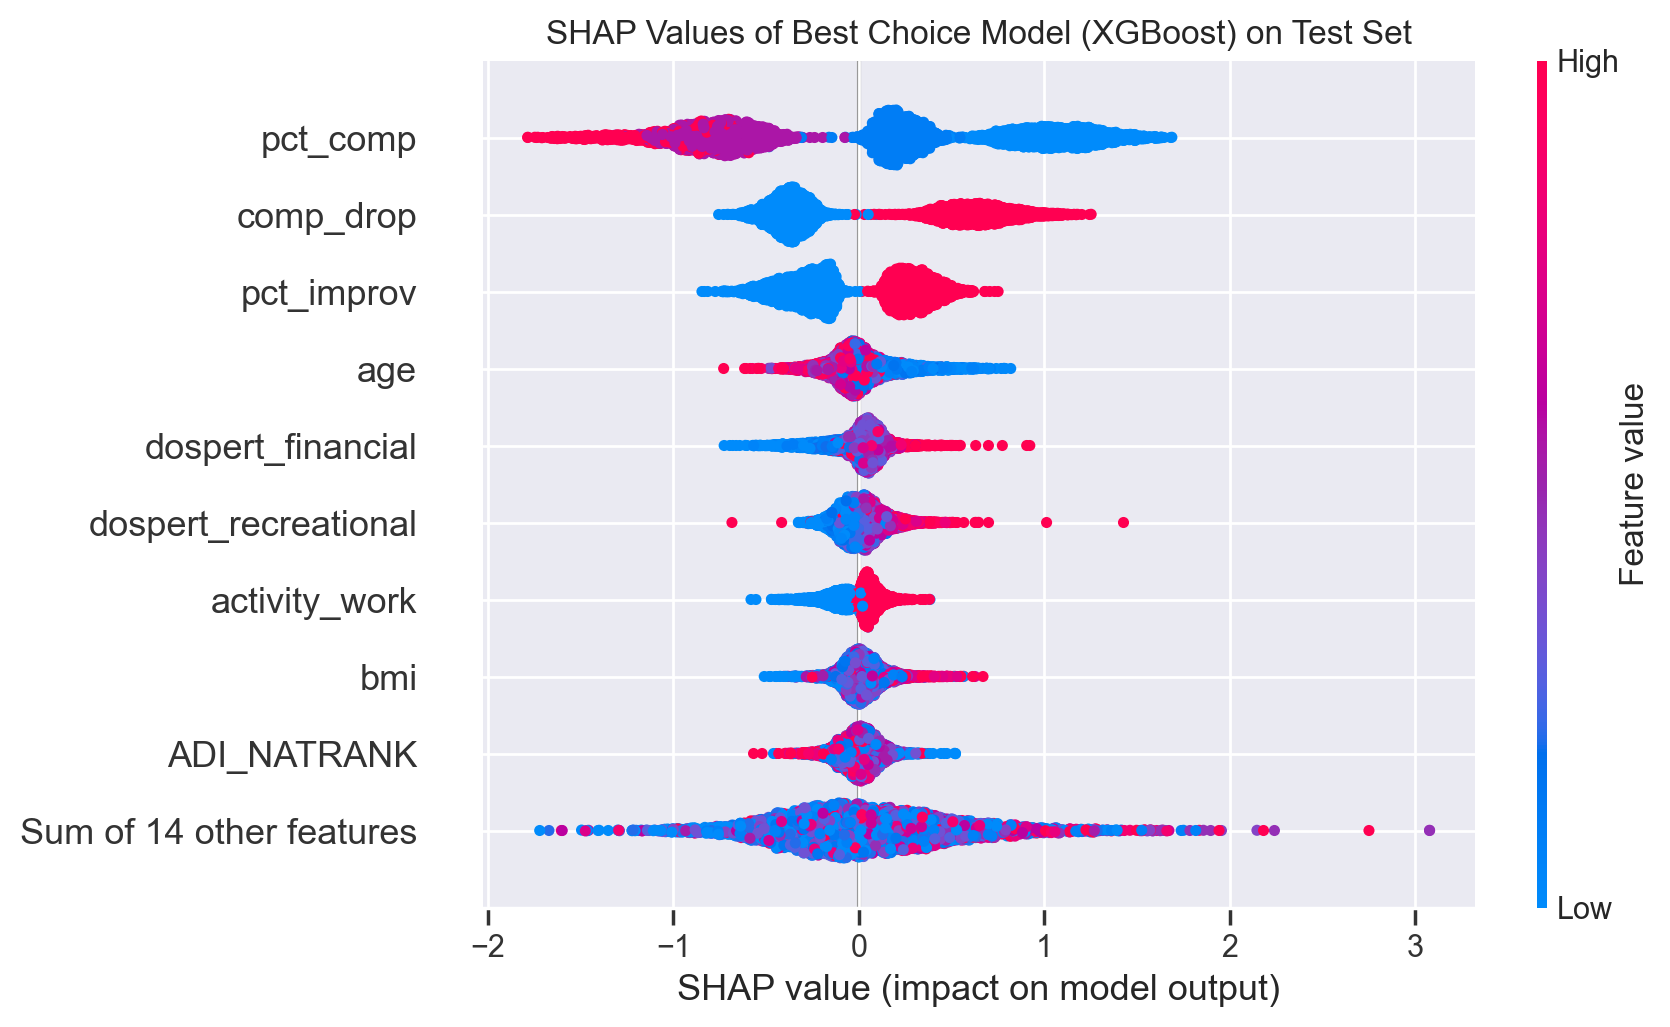

In [51]:
fig = plt.figure(figsize=(10, 10), dpi=200)
shap.plots.beeswarm(shap_values, show=False)
plt.title('SHAP Values of Best Choice Model (XGBoost) on Test Set')